# Final and Best Model Visualizations


In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from scipy.ndimage.filters import uniform_filter1d
import time
%matplotlib inline
#from IPython.display import display, clear_output

import LSTM as ml
import nasa_data_funcs_v4 as ndf  #v4 removes the VRTG, LONG, LATG

import pyarrow as pa

/tmp/ipykernel_2247927/74279571.py:9: DeprecationWarning: Please use `uniform_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter1d


In [4]:
#setting the cuda device

use_cpu = True

if torch.cuda.is_available() and not use_cpu:
    cuda0 = torch.device('cuda:0')
    cuda1 = torch.device('cuda:1')
    cuda2 = torch.device('cuda:2')
    cuda3 = torch.device('cuda:3')
    device = cuda1
else:
    device = torch.device('cpu')

#torch.cuda.set_device(device)a
device

device(type='cpu')

In [6]:
#loading the pre-trained model

#this model is from the regular methodology and matches the average MSE of the papers analysis of this methodology
model_name = 'Tail_687_1_parquet/RecurrentNeuralNetwork_rand-multiflight_loop_noVRTG_batch_newParams2-3_update_config4_bootloop2_best.pt'
#model_name = 'Tail_687_1_parquet/RecurrentNeuralNetwork_rand-multiflight_loop_noVRTG_batch_newParams2-3_update_config4_bootloop0.pt'
#model_name = 'Tail_687_1_parquet/RecurrentNeuralNetwork_rand-multiflight_loop_noVRTG_batch_newParams2-3_update_config4_bootloop1.pt'


#previous best model
#model_name = 'Tail_687_1_parquet/RecurrentNeuralNetwork_rand-multiflight_loop_noVRTG_batch_newParamsBest9.pt'


#this model is the last file saved from the regular methodology and has the average MSE in the model card
#  5.281388949166891e-05
#model_name = 'RecurrentNeuralNetwork_rand-multiflight_loop_noVRTG_batch_newParamsBest_w-avgMSE.pt'

#this model has the average MSE over the whole bootstrap loop
#model_name = 'RecurrentNeuralNetwork_rand-multiflight_loop_noVRTG_batch_newParamsBest_randfiles.pt'

#this model has close to the actual MSE that was average for the end of the methodology
#model_name = 'RecurrentNeuralNetwork_rand-multiflight_loop_noVRTG_batch_newParamsBest_randfiles6.pt'

#model = torch.load(model_name, map_location=device)

model = torch.load(model_name, map_location=device)
model.to(device) #sending full model to the correct device
model.device = device #setting the internal "device" variable to the right device when running LSTM forward

cwd = os.getcwd()

#this directory is currently hard-coded in (I know, Not great), so that means this python
# jupyter notebook needs to be run in the same directory as the data
fdir = 'Tail_687_1_parquet'

#custom built __repr__ function in LSTM to spit out data I wanted
model.eval()

/home/boothtm/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


LSTM(Base+removeVar, 23, 1, 16, 0.0007, 20, 1 )

In [7]:
print(f'{model.test_mse=}')
print(f'{model.bootloop_avg_test_mse=}')
print(f'{model.device=}')
print(f'{model.hidden_units=}')
print(f'{model.seq_length=}')
print(f'{model.learning_rate=}')
print(f'{model.approach=}')
print(f'{model.n_epochs=}')
print(f'{model.unit_processing=}')
print(f'{model.model_size=}')
print(f'{model.scaleT=}')
print(f'{model.device=}')
#print(f'{model.model_size_wcard=}')

model.test_mse=1.0885067922572489e-06
model.bootloop_avg_test_mse=2.933555492745654e-06
model.device=device(type='cpu')
model.hidden_units=20
model.seq_length=16
model.learning_rate=0.0007
model.approach='Base+removeVar'
model.n_epochs=3500
model.unit_processing=1.796907268230907e-09
model.model_size=15872
model.scaleT=MinMaxScaler()
model.device=device(type='cpu')


In [ ]:
## Scaling MSE to real units of feet


In [8]:
#real_mse = model.scaleT.inverse_transform(np.array([model.test_mse]).reshape(-1,1))[0,0] #inverse transform expects 2D array

print(f'The scaled MSE: {model.test_mse}\n')
#print(f'The real MSE in units of Feet: {real_mse}')

The scaled MSE: 1.0885067922572489e-06



In [ ]:
## Plotting testing results from the model

In [9]:
model.test_files

['687200107241524.parquet',
 '687200104301119.parquet',
 '687200104261527.parquet',
 '687200104181334.parquet',
 '687200107301239.parquet',
 '687200104170717.parquet',
 '687200107170234.parquet']

In [10]:
#load the testing files and scale by the data saved in the model cards
Xtestdf, Ttestdf, Timetest, scaleX, scaleT = \
    ndf.read_parquet_flight_merge(cwd, fdir, model.test_files, model.seq_length, scaleX=model.scaleX, scaleT=model.scaleT)


#create tensors from the data frames
Xtest = torch.from_numpy(Xtestdf.astype(np.float32)).to(device)
Ttest = torch.from_numpy(Ttestdf.astype(np.float32)).to(device)

#Xtest.to(device)


test_output = model(Xtest)

#Define the loss function used to calculate the difference between the model output and the training Target
#loss_func = torch.nn.MSELoss()

#calculate the loss of the model output (Y) to the training Target (Ttrain)
#loss = loss_func(test_output, Ttest).detach().cpu()  

/ssd/MBSE/phd/research/work_folder/NASA_big_data/nasa_data_funcs_v4.py:243: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Xdf = Xdf.append(Xdfnew)
/ssd/MBSE/phd/research/work_folder/NASA_big_data/nasa_data_funcs_v4.py:244: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tdf = Tdf.append(Tdfnew)
/ssd/MBSE/phd/research/work_folder/NASA_big_data/nasa_data_funcs_v4.py:243: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Xdf = Xdf.append(Xdfnew)
/ssd/MBSE/phd/research/work_folder/NASA_big_data/nasa_data_funcs_v4.py:244: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tdf = Tdf.append(Tdfnew)
/ssd/MBSE/phd/research/work_folder/NASA_big_data/nasa_da

In [11]:
#removing the scaling factor to plot in real units
Ttest_alt = scaleT.inverse_transform(Ttestdf) #target altitude
Ytest_alt = scaleT.inverse_transform(test_output.detach().cpu().numpy()) #model altitude

In [16]:
Ytest_alt[:,0]

array([935.00867, 932.6053 , 932.5948 , ..., 824.3031 , 824.29083,
       823.77246], dtype=float32)

In [17]:
Ytest_table = pa.table({"data": Ytest_alt[:,0]})
pa.parquet.write_table(Ytest_table, "model_alt.parquet")

In [11]:
#max altitude index of target altitude array
np.where(Ttest_alt == 27000)

(array([216805, 216806, 216807, 216808]), array([0, 0, 0, 0]))

In [12]:
#where the index is for the GMT time
np.where(np.round(Timetest) == 30001)


(array([372540, 372541, 372542, 372543, 372544, 372545, 372546, 372547,
        372548, 372549, 372550, 372551, 372552, 372553, 372554, 372555]),)

In [13]:
diff_alt = Ttest_alt - Ytest_alt

window = 10000
istart = 300000
istop  = istart+window
max(abs(diff_alt[istart:istop]))
max(abs(diff_alt))

array([1314.78515625])

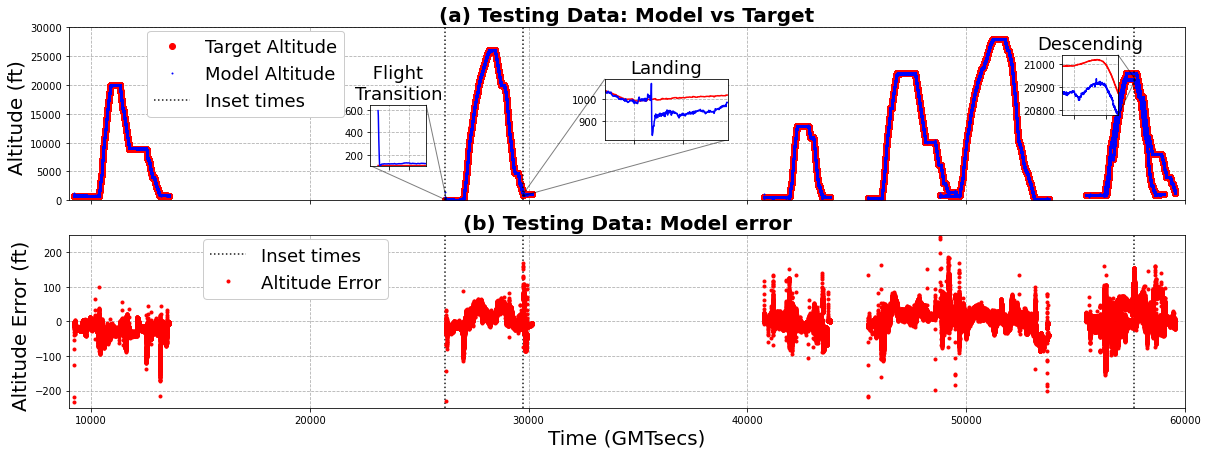

In [46]:
fig = plt.figure(figsize=(20, 7))

#number of vertical subplots
nv = 2

#subplot 1
ax1 = plt.subplot(nv,1,1)
#ax1 = plt.gca()
#ax1.set_title('Testing Data', fontsize=20)
ylim1 = 30000
ax1.set_title('(a) Testing Data: Model vs Target', fontsize=20, fontweight="bold")
plt.plot(Timetest, Ttest_alt, 'ro', label='Target Altitude')
plt.plot(Timetest, Ytest_alt, 'b.', label='Model Altitude', markersize=2)
plt.ylim(0,ylim1)
plt.xlim(9000, 60000)
# plt.legend(fontsize=18, framealpha=1, loc=[0.05, 0.65])
plt.ylabel('Altitude (ft) ',fontsize=20)
#plt.xlabel('Time (GMTsecs)',fontsize=20);
plt.tick_params(axis='x', labelbottom=False) # labels along the bottom edge are off
plt.grid(linestyle='--')

#----------------inset axes 1-----------------------
axins1 = ax1.inset_axes([0.48, 0.35, 0.11, 0.35])

axins1.set_title('Landing', fontsize=18)

window = 400
istart = 368600
istop  = istart+window
axins1.plot(Timetest[istart:istop], Ttest_alt[istart:istop], 'r-', label='Pressure Altitude "truth"')
axins1.plot(Timetest[istart:istop], Ytest_alt[istart:istop], 'b-', label='Model Altitude')
axins1.grid(linestyle='--')

# sub region of the original image
x1, x2, y1, y2 = Timetest[istart], Timetest[istop], min(Ytest_alt[istart:istop]), max(Ytest_alt[istart:istop])
axins1.set_xlim(x1, x2)
axins1.set_ylim(y1-20, y2+20)
axins1.set_xticklabels([])
#axins1.set_yticklabels([])
ax1.indicate_inset_zoom(axins1, edgecolor="black")
istart1=istart

#---------------------inset axes 2-----------------
axins2 = ax1.inset_axes([0.27, 0.2, 0.05, 0.35])
axins2.set_title(' Flight \nTransition', fontsize=18)
window = 200
istart = 311820
istop  = istart+window
axins2.plot(Timetest[istart:istop], Ttest_alt[istart:istop], 'r-', label='Pressure Altitude "truth"')
axins2.plot(Timetest[istart:istop], Ytest_alt[istart:istop], 'b-', label='Model Altitude')
axins2.grid(linestyle='--')

# sub region of the original image
x1, x2, y1, y2 = Timetest[istart], Timetest[istop], min(Ttest_alt[istart:istop]), max(Ytest_alt[istart:istop])
axins2.set_xlim(x1-2, x2)
axins2.set_ylim(y1, y2+50)
axins2.set_xticklabels([])
#axins2.set_yticklabels([])
ax1.indicate_inset_zoom(axins2, edgecolor="black");
istart2=istart

# #---------------------inset axes 3-----------------
# axins3 = ax1.inset_axes([0.12, 0.12, 0.10, 0.35])
# axins3.set_title('Descending', fontsize=18)
# window = 400
# istart = 427600
# istop  = istart+window
# axins3.plot(Timetest[istart:istop], Ttest_alt[istart:istop], 'r-', label='Pressure Altitude "truth"')
# axins3.plot(Timetest[istart:istop], Ytest_alt[istart:istop], 'b-', label='Model Altitude')
# axins3.grid(linestyle='--')

# # sub region of the original image
# x1, x2, y1, y2 = Timetest[istart], Timetest[istop], min(Ttest_alt[istart:istop]), max(Ytest_alt[istart:istop])
# axins3.set_xlim(x1, x2)
# axins3.set_ylim(y1, y2)
# axins3.set_xticklabels([])
# axins3.set_yticklabels([])
# ax1.indicate_inset_zoom(axins3, edgecolor="black");
# istart3=istart

#---------------------inset axes 4-----------------
axins4 = ax1.inset_axes([0.89, 0.49, 0.05, 0.35])
axins4.set_title('Descending', fontsize=18)
window = 700
istart = 138500
istop  = istart+window
axins4.plot(Timetest[istart:istop], Ttest_alt[istart:istop], 'r-', label='Pressure Altitude "truth"')
axins4.plot(Timetest[istart:istop], Ytest_alt[istart:istop], 'b-', label='Model Altitude')
axins4.grid(linestyle='--')

# sub region of the original image
x1, x2, y1, y2 = Timetest[istart], Timetest[istop], min(Ytest_alt[istart:istop]), max(Ttest_alt[istart:istop])
axins4.set_xlim(x1, x2)
axins4.set_ylim(y1, y2+20)
axins4.set_xticklabels([])
#axins4.set_yticklabels([])
ax1.indicate_inset_zoom(axins4, edgecolor="black");
istart4=istart

plt.plot([Timetest[istart1], Timetest[istart1]], [0, ylim1], 'k:', alpha=0.9, label='Inset times')
plt.plot([Timetest[istart2], Timetest[istart2]], [0, ylim1], 'k:', alpha=0.9)
# plt.plot([Timetest[istart3], Timetest[istart3]], [0, ylim1], 'b--')
plt.plot([Timetest[istart4], Timetest[istart4]], [0, ylim1], 'k:', alpha=0.9)
plt.legend(fontsize=18, framealpha=1, loc=[0.07, 0.48])

#---------------------------------------
# error plots
diff_alt = Ttest_alt - Ytest_alt
ylim = 250

#subplot 1
ax2 = plt.subplot(nv,1,2)
#ax1.set_title('Testing Data', fontsize=20)
ax2.set_title('(b) Testing Data: Model error', fontsize=20, fontweight="bold")
plt.plot([Timetest[istart1], Timetest[istart1]], [-ylim, ylim], 'k:', alpha=0.9, label='Inset times')
plt.plot([Timetest[istart2], Timetest[istart2]], [-ylim, ylim], 'k:', alpha=0.9)
# plt.plot([Timetest[istart3], Timetest[istart3]], [-ylim, ylim], 'b--')
plt.plot([Timetest[istart4], Timetest[istart4]], [-ylim, ylim], 'k:', alpha=0.9)
plt.plot(Timetest, diff_alt, 'r.', label='Altitude Error')

#plt.plot(Timetest, Ytest_alt, 'b.', label='Model Altitude')
plt.ylim(-ylim, ylim)
plt.xlim(9000,60000)
plt.legend(fontsize=18, framealpha=1, loc=[0.12, 0.63])
plt.ylabel('Altitude Error (ft) ',fontsize=20)
plt.xlabel('Time (GMTsecs)',fontsize=20);
plt.grid(linestyle='--')




plt.savefig("figures/target_vs_model_altitude_20x8.png", bbox_inches='tight', dpi='figure');



In [15]:
#error standard deviation of best model
diff_alt.std()

29.691831250411887

In [35]:
window = 1000
istart = 138500
max(diff_alt[istart:istart+window])

array([155.4375])

In [16]:
np.where(np.round(Timetest) == 58001)

(array([ 40627,  40628,  40629,  40630,  40631,  40632,  40633,  40634,
         40635,  40636,  40637,  40638,  40639,  40640,  40641,  40642,
        143852, 143853, 143854, 143855, 143856, 143857, 143858, 143859,
        143860, 143861, 143862, 143863, 143864, 143865, 143866, 143867]),)